In [2]:
import numpy as np
import numpy.linalg as la
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Implementing Simple Linear Regression 

In [100]:
class SimpleLinearRegression():
    """
        Class for implementing Simple Linear Regression.
    """

    def __init__(self) -> None:
        pass

    def fit(self, X, y):
        """
            Used to calculate b0(intercept) & b1(slope)
            : param X: array, single feature
            : param y: array, label or true values
            : return: None
        """
        XMean = np.mean(X)
        yMean = np.mean(y)

        self.slope = np.dot(np.squeeze(np.asarray(X - XMean)), np.squeeze(np.asarray(y - yMean))) / np.sum((X - XMean) ** 2)
        self.intercept = float(float(yMean) - (self.slope * float(XMean)))

    def predict(self, x):
        """
            Used to predict the value of y
            : param X: array, single feature
            : return: array, predicted values
        """

        return self.intercept + (self.slope * x)


class SimpleLinearRegressionGradientDescent(SimpleLinearRegression):
    """
        Class for implementing Simple Linear Regression with Gradient Descent Method
    """

    def __init__(self, slope = 0, intercept = 0) -> None:
        self.slope = slope
        self.intercept = intercept

    def fit(self, X, y, epochs = 10**6, learning_rate = 10**-5):
        """
            Used to calculate b0(intercept) & b1(slope)
            : param X: array, single feature
            : param y: array, label or true values
            : param epochs: number, number of iterations
            : param learning_rate: number, learning rate for the model
            : return: None
        """

        X = np.array(X)
        y = np.array(y)
        n = len(y)

        for i in range(0, epochs):            
            partial = np.subtract(self.predict(X), y)
            partial0 = (np.sum(partial) * 2) / n
            partial1 = (np.dot(partial , X) * 2) / n

            if math.isnan(partial0) or math.isnan(partial1) :
                break
        
            self.slope -= learning_rate * partial1
            self.intercept -= learning_rate * partial0

### Implementing Multiple Linear Regression 

In [4]:
verySmallNumber = 1e-14 # That's 1×10⁻¹⁴ = 0.00000000000001


class MultipleLinearRegression():
    """
        Class for implementing Multiple Linear Regression.
    """

    def __init__(self) -> None:
        self.regression_coefficients = None

    def fit(self, X, y):
        """
            Used to calculate regression coefficients
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : return: None
        """

        X = np.array(X)
        y = np.array(y)

        np.insert(X, 0, 1, 0)
        X = X.astype('float64')
        self.regression_coefficients = la.inv(np.transpose(X) @ X) @ np.transpose(X) @ y

    def predict(self, X):
        """
            Used to predict the value of y
            : param X: 2D array, matrix of features, with each row being a data entry
            : return: array, predicted values
        """

        X = np.array(X)
        np.insert(X, 0, 1, 0)
        return X @ self.regression_coefficients

    
class MultipleLinearRegressionGradientDescent(MultipleLinearRegression):
    """
        Class for implementing Multiple Linear Regression with Gradient Descent Method
    """

    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y, epochs = 10**5, learning_rate = 10**-5):
        """
            Used to calculate b0(intercept) & b1(slope)
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : param epochs: number, number of iterations
            : param learning_rate: number, learning rate for the model
            : return: None
        """

        X = np.array(X)
        y = np.array(y)
        n = len(y) # If getting nan values as results for prediction, partial values becoming inf could be the reason. Scaling n to a large value helps. for example n = len(y) * 10**6 OR Try feature scaling for the data
        np.insert(X, 0, 1, 0)
        X = X.astype('float64')
        p = X.shape[1]
        self.regression_coefficients = np.zeros(p)
        cost = []

        for i in range(0, epochs):    
            pred = self.predict(X)
            cost.append(Metrics().root_mean_squared_error(y, pred))
            partial = np.subtract(pred, y)
            self.regression_coefficients[0] = (np.sum(partial) * 2) / n

            for i in range(1,p):
                partiali = (np.dot(partial , X[:, i]) * 2) / n
                if (math.isnan(partiali)):
                    return
                self.regression_coefficients[i] -= learning_rate *  partiali
        
        return cost
        
    


class MultipleLinearRegressionGramSchmidt(MultipleLinearRegression):
    """
        Class for implementing Multiple Linear Regression using Successive Orthogonolization(Gram Schmidt Process/Orthogonolization)
    """

    def __init__(self) -> None:
        super().__init__()
        self.Q = None 
        self.R = None

    def gsBasis(self, X) :
        """
            Used to Orthonormalize matrix X
            : param X: 2D array, matrix of features, with each row being a data entry
            : return: 2D array, column matrix of residuals/ orthonormalized matrix
        """
        
        B = np.array(X, dtype=np.float_) # Make B as a copy of X, since we're going to alter it's values.
        # Loop over all vectors, starting with zero, label them with i
        for i in range(B.shape[1]) :
            # Inside that loop, loop over all previous vectors, j, to subtract.
            for j in range(i) :
                # Complete the code to subtract the overlap with previous vectors.
                # you'll need the current vector B[:, i] and a previous vector B[:, j]
                B[:, i] = B[:, i] - B[:, i] @ B[:, j] * B[:, j]
            # Next insert code to do the normalisation test for B[:, i]
            if la.norm(B[:, i]) > verySmallNumber :
                B[:, i] = B[:, i] / la.norm(B[:, i])
            else :
                B[:, i] = np.zeros_like(B[:, i])
                
            
                
        # Finally, we return the result:
        return B


    def fit(self, X, y):
        """
            Used to calculate regression coefficients, Q and R matrices of QR decomposition
            : param X: 2D array, matrix of features, with each row being a data entry
            : param y: array, label or true values
            : return: None
        """

        np.insert(X, 0, 1, 0)
        X = X.astype('float64')

        self.Q = self.gsBasis(X)
        self.R = np.transpose(self.Q) @ X
        self.regression_coefficients = la.inv(self.R) @ np.transpose(self.Q) @ y


### Implementing Preprocessing Functions

In [5]:
class Preprocessing():
    """
        Class for implementing preprocessing functions to normalize data.
    """
    def __init__(self):
        pass
    
    def mean_normalization(self, X, train = False):
        """
            Used to apply mean normalization to the data.
            : param X: scalar or array,
            : param train: boolean, true if training set if being normalized, false otherwise 
            : return: 2D array, normalized data
        """
        if train:
            self.mean = X.mean()
            self.max = X.max()
            self.min = X.min()
        normalized_df = (X - self.mean) / (self.max - self.min)
        return normalized_df
    
    def standardization(self, X, train = False):
        """
            Used to apply standardization to the data.
            : param X: scalar or array,
            : param train: boolean, true if training set if being normalized, false otherwise 
            : return: 2D array, normalized data
        """
        if train:
            self.mean = X.mean()
            self.std = X.std()
        normalized_df = (X - self.mean) / self.std
        return normalized_df

### Implementing Utility functions to measure regression performance

In [6]:
class Metrics():
    """
        Class for implementing several loss, score, and utility functions to measure regression performance. 
    """
    def __init__(self):
        pass
    
    def mean_squared_error(self, y, y_pred):
        """
            Used to calculate Mean Squared Error (MSE)
            : param y: array, label or true values
            : param y_pred: array, predicted values
            : return: scalar, MSE of the model
        """
        n = len(y)
        mse = np.sum((y - y_pred) ** 2) / n
        return mse
    
    def root_mean_squared_error(self, y, y_pred):
        """
            Used to calculate Root Mean Squared Error (RMSE)
            : param y: array, label or true values
            : param y_pred: array, predicted values
            : return: scalar, RMSE of the model
        """
        return np.sqrt(self.mean_squared_error(y, y_pred))
    
    def mean_absolute_error(self, y, y_pred):
        """
            Used to calculate Mean Absolute Error (MAE)
            : param y: array, label or true values
            : param y_pred: array, predicted values
            : return: scalar, MAE of the model
        """
        n = len(y)
        mae = np.sum(np.abs(y - y_pred)) / n
        return mae

### Implementing functions to split data into train and test sets

In [7]:
class TrainTestSplit():
    def __init__(self):
        pass

    def split_train_test_data(self, X, y, train_set = 0.8, test_set = 0.2):
        n = len(X.index)

        train_X = X.iloc[: int(n * train_set), :]
        test_X = X.iloc[int(n * train_set):, :]
        
        train_y = y.iloc[: int(n * train_set)]
        test_y = y.iloc[int(n * train_set):]

        return train_X, train_y, test_X, test_y

## Simple Linear Regression

### Reading data from the csv file

In [8]:
df = pd.read_csv('/content/Advertising.csv')
df.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


### Splitting features and target variable

In [70]:
X = pd.DataFrame(df['TV'])
y = pd.DataFrame(df['Sales'])

### Splitting train and test data

In [71]:
train_X, train_y, test_X, test_y = TrainTestSplit().split_train_test_data(X, y)

Text(0, 0.5, 'Sales')

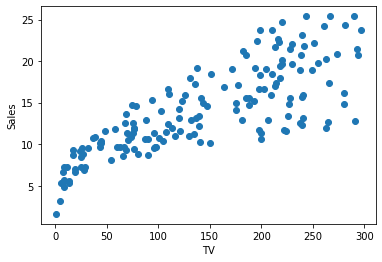

In [72]:
plt.scatter(train_X, train_y)
plt.xlabel("TV")
plt.ylabel("Sales")

### Training the regression model

In [101]:
rgr = SimpleLinearRegression()
rgr.fit(train_X, train_y)

In [102]:
test_X.reset_index(drop=True, inplace=True)
y_pred = rgr.predict(test_X)

In [103]:
y_pred

,TV
0,15.510179
1,11.262564
2,16.288256
3,15.069758
4,12.804037
5,18.544190
6,7.944726
7,17.188672
8,17.609519
9,20.981186


### Calculating the metrics of our model and comparing them with sklearn's model

In [104]:
metrics = Metrics()
metrics.mean_squared_error(test_y, y_pred)

Sales    0.0
TV       0.0
dtype: float64

In [105]:
rgr.slope

TV    0.048936
dtype: float64

In [106]:
rgr.intercept

7.06877766590613

### Plotting regression lines

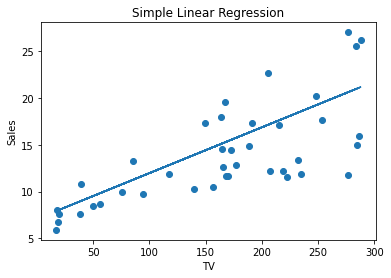

In [109]:
plt.scatter(test_X, test_y)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title("Simple Linear Regression")
plt.plot(test_X, y_pred)

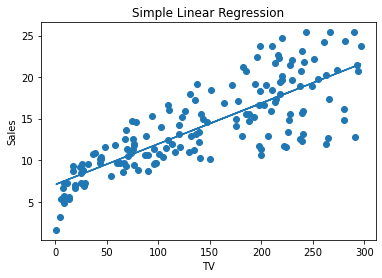

In [110]:
plt.scatter(train_X, train_y)
plt.xlabel("TV")
plt.ylabel("Sales")
plt.title("Simple Linear Regression")
plt.plot(train_X, rgr.predict(train_X))

## Multiple Linear Regression

### Reading data from the csv file

In [ ]:
df = pd.read_csv('/content/sample_data/california_housing_train.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


### Splitting features and target variable

In [ ]:
X = df.drop('median_house_value', axis = 1)
y = df['median_house_value']

### Splitting train and test data

In [ ]:
train_X, train_y, test_X, test_y = TrainTestSplit().split_train_test_data(X, y)

### Data preprocessing

In [ ]:
X_pr = Preprocessing()
train_X = X_pr.mean_normalization(train_X, train = True)
test_X = X_pr.mean_normalization(test_X)

y_pr = Preprocessing()
train_y = y_pr.mean_normalization(train_y, train = True)
test_y = y_pr.mean_normalization(test_y)

In [ ]:
train_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,0.592523,-0.087216,-0.241742,0.077239,0.113914,-0.013132,-0.006055,-0.159781
1,0.571662,-0.064684,-0.163310,0.130963,0.209832,-0.009937,-0.007535,-0.137271
2,0.559928,-0.140864,-0.202526,-0.051718,-0.058211,-0.032247,-0.064443,-0.148933
3,0.558624,-0.146229,-0.261349,-0.031130,-0.032912,-0.027146,-0.046515,-0.042672
4,0.558624,-0.153740,-0.143702,-0.032369,-0.034620,-0.024091,-0.040594,-0.130030
...,...,...,...,...,...,...,...,...
13595,-0.407477,0.358063,-0.182918,0.031477,0.056953,0.025294,0.058912,-0.083906
13596,-0.407477,0.358063,-0.280957,0.024623,0.019082,0.015092,0.023551,0.016768
13597,-0.407477,0.352698,-0.457428,0.160698,0.115155,0.070811,0.111708,0.112374
13598,-0.407477,0.326947,0.071984,0.003376,-0.004820,0.004385,-0.000956,-0.030645


In [ ]:
test_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13600,-0.407477,0.317290,-0.104487,0.008042,0.002165,-0.001781,0.005130,-0.011066
13601,-0.407477,0.317290,-0.300565,0.062372,0.088925,0.020333,0.083090,-0.045044
13602,-0.407477,0.316217,-0.222134,0.007963,-0.022203,-0.004668,-0.018390,0.204938
13603,-0.407477,0.316217,-0.261349,0.095112,0.047330,0.034767,0.051182,0.201835
13604,-0.407477,0.302269,-0.182918,0.169634,0.108481,0.050351,0.108255,0.289137
...,...,...,...,...,...,...,...,...
16995,-0.704739,0.598406,0.483749,-0.012256,-0.024065,-0.016159,-0.022995,-0.100230
16996,-0.706043,0.610209,0.170023,-0.008776,-0.003268,-0.008115,-0.007206,-0.089140
16997,-0.709954,0.733599,-0.202526,-0.000130,-0.002802,-0.006714,-0.008686,-0.053734
16998,-0.709954,0.729307,-0.163310,-0.000262,0.000457,-0.005200,-0.005068,-0.126257


### Training the regression model

In [ ]:
rgr = MultipleLinearRegression()
rgr.fit(train_X, train_y)

In [ ]:
test_X.reset_index(drop=True, inplace=True)
y_pred = rgr.predict(test_X)

In [ ]:
rgr.regression_coefficients

array([-0.63609601, -0.7884746 ,  0.10341858, -0.65383989,  1.56359328,
       -2.61934256,  0.42270182,  1.19288361])

### Calculating the metrics of our model and comparing them with sklearn's model

In [ ]:
metrics = Metrics()
metrics.mean_squared_error(test_y, y_pred)

0.023844357829476914

In [ ]:
metrics.mean_absolute_error(test_y, y_pred)

0.1161134568956993

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

In [ ]:
reg.coef_

array([-0.63609601, -0.7884746 ,  0.10341858, -0.65383989,  1.56359328,
       -2.61934256,  0.42270182,  1.19288361])

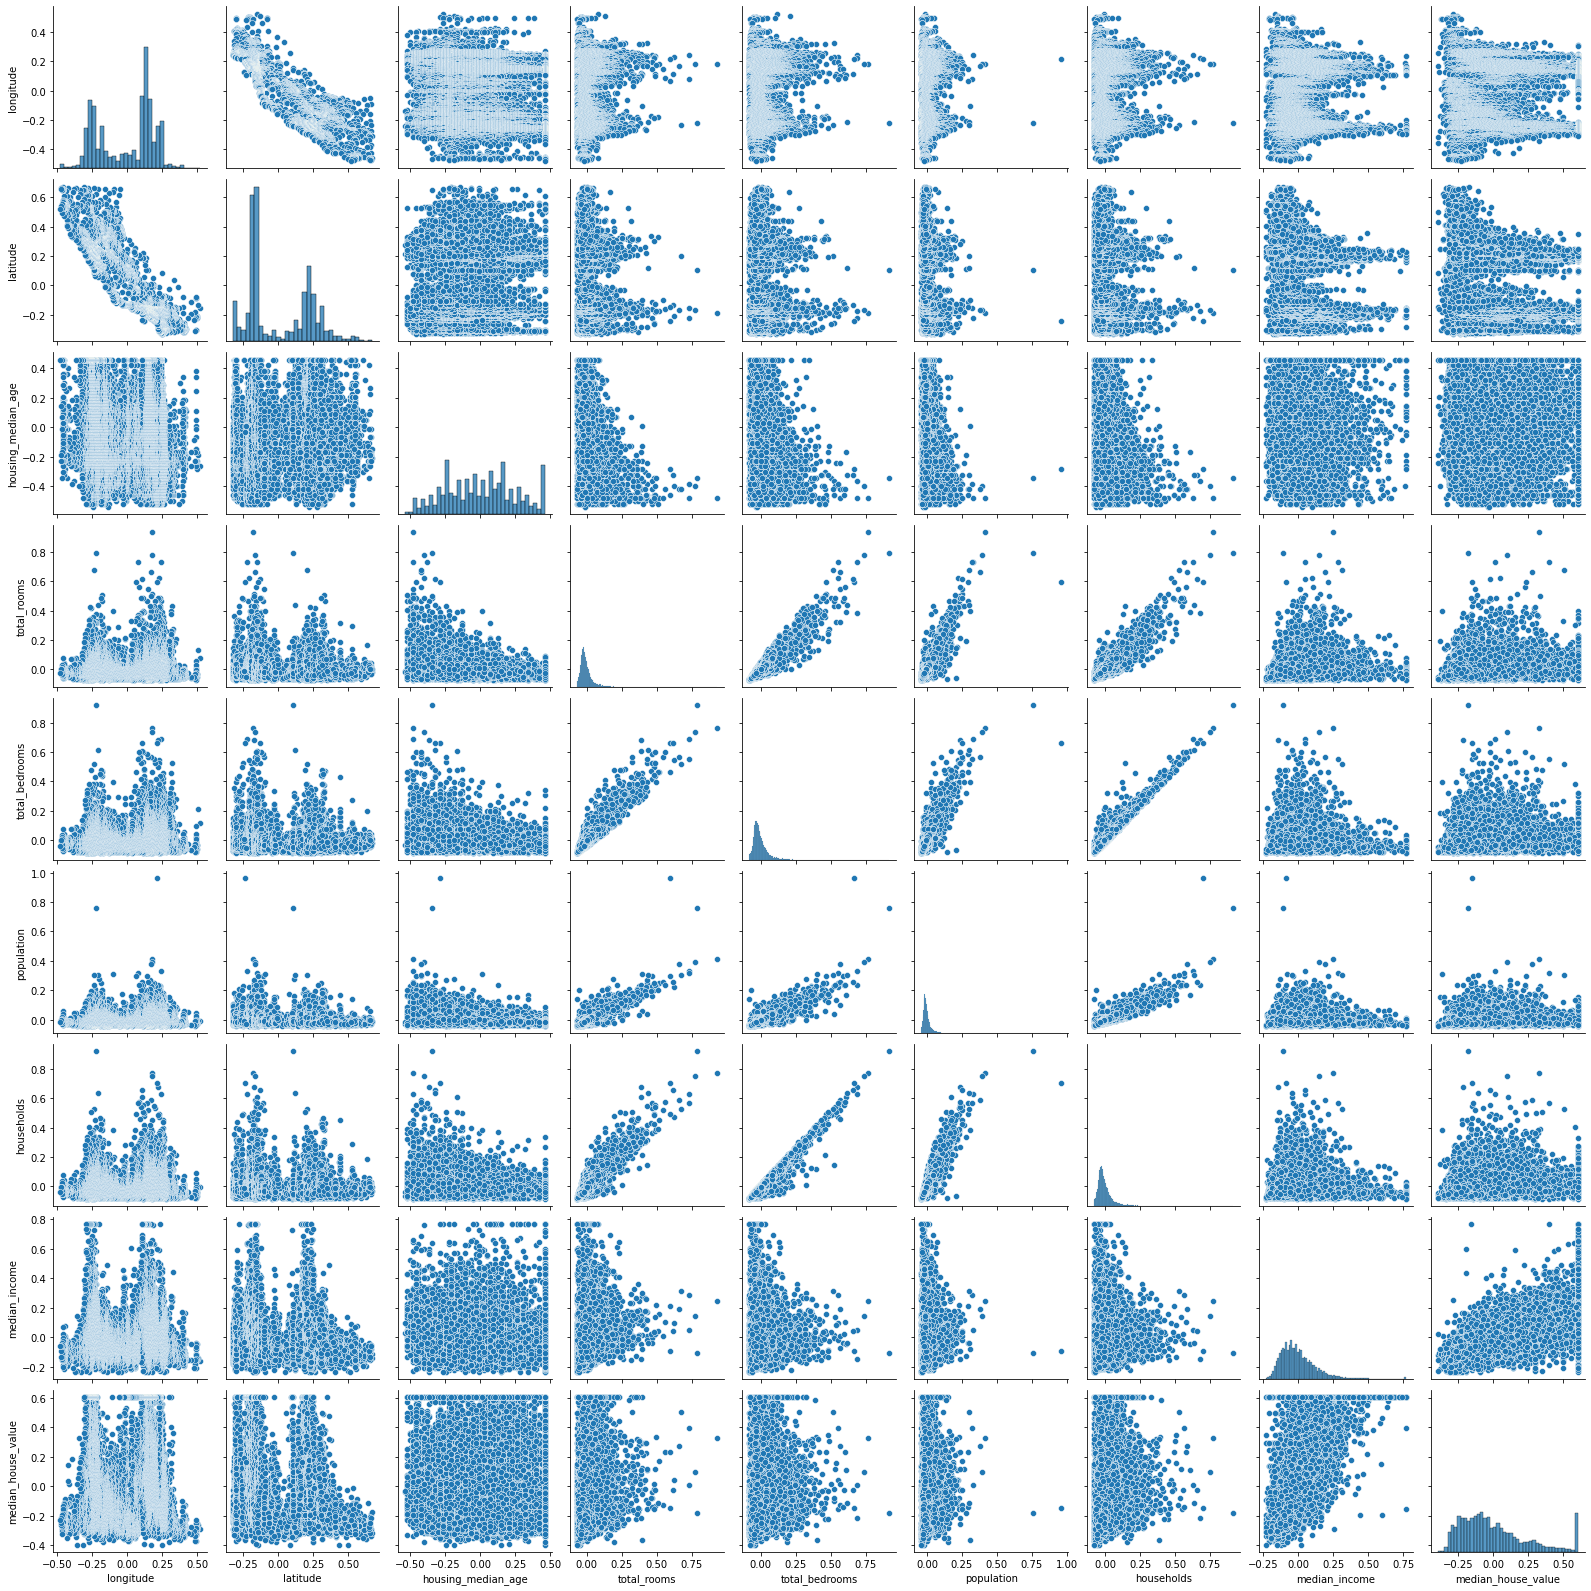

In [ ]:
sns.pairplot(Preprocessing().mean_normalization(df, True))

## Polynomial Regression

### Adding polynomial features

In [ ]:
poly_df = df.copy()
poly_df['total_rooms_squared'] = df['total_rooms'] ** 2
poly_df['households_squared'] = df['households'] ** 2
poly_df['population_squared'] = df['population'] ** 2
poly_df['total_bedrooms_squared'] = df['total_bedrooms'] ** 2

### Training Polynomial Regression model

In [ ]:
X = poly_df.drop('median_house_value', axis = 1)
y = poly_df['median_house_value']

train_X, train_y, test_X, test_y = TrainTestSplit().split_train_test_data(X, y)

X_pr = Preprocessing()
train_X = X_pr.mean_normalization(train_X, train = True)
test_X = X_pr.mean_normalization(test_X)

y_pr = Preprocessing()
train_y = y_pr.mean_normalization(train_y, train = True)
test_y = y_pr.mean_normalization(test_y)

In [ ]:
rgr = MultipleLinearRegression()
rgr.fit(train_X, train_y)

test_X.reset_index(drop=True, inplace=True)
y_pred = rgr.predict(test_X)

In [ ]:
rgr.regression_coefficients

array([-0.63046399, -0.77932214,  0.10449993, -1.77121973,  3.98828332,
       -4.19576497, -0.11590158,  1.2476028 ,  2.57486958,  2.59336878,
        3.50509806, -5.97740568])

### Calculating the metrics of our model and comparing them with sklearn's model

In [ ]:
metrics.mean_absolute_error(test_y, y_pred)

0.11472818067305099

In [ ]:
metrics.mean_squared_error(test_y, y_pred)

0.02297577819824229

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(train_X, train_y)

In [ ]:
reg.coef_

array([-0.63046399, -0.77932214,  0.10449993, -1.77121973,  3.98828332,
       -4.19576497, -0.11590158,  1.2476028 ,  2.57486958,  2.59336878,
        3.50509806, -5.97740568])

### Training Multiple Linear Regression with Gradient Descent model

In [ ]:
rgr = MultipleLinearRegressionGradientDescent()
rmse = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 15)

test_X.reset_index(drop=True, inplace=True)
y_pred = rgr.predict(test_X)

In [ ]:
rgr.regression_coefficients

array([ 1.92891454e-15, -1.77061739e-01,  1.43122306e-01, -1.59655381e+00,
        1.64947179e+00, -3.06188131e+00,  1.55934146e+00,  1.34471138e+00,
        1.15871870e+00, -3.60604281e-01,  1.81639639e+00, -1.39295585e+00])

In [ ]:
metrics.mean_squared_error(test_y, y_pred)

0.03522507480312522

### Visualizing Gradient Descent

Text(0.5, 0, 'Epochs')

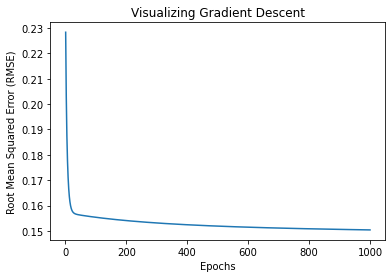

In [ ]:
plt.plot(range(1,1001), rmse)
plt.title("Visualizing Gradient Descent")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.xlabel("Epochs")

### Effect of Learning Rate on Convergence of Gradient Descent

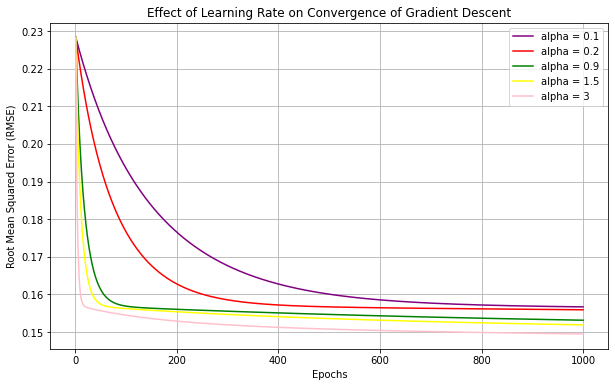

In [ ]:
rmse1 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 0.1)
rmse2 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 0.2)
rmse3 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 0.9)
rmse4 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 1.5)
rmse5 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 5)

plt.plot(range(1, 1001), rmse1, color='purple', label = 'alpha = 0.1')
plt.plot(range(1, 1001), rmse2, color='red', label = 'alpha = 0.2')
plt.plot(range(1, 1001), rmse3, color='green', label = 'alpha = 0.9')
plt.plot(range(1, 1001), rmse4, color='yellow', label = 'alpha = 1.5')
plt.plot(range(1, 1001), rmse5, color='pink', label = 'alpha = 3')

plt.rcParams['figure.figsize'] = (10, 6)
plt.grid()
plt.title('Effect of Learning Rate on Convergence of Gradient Descent')
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()

### Effect of very high Learning Rate on Convergence of Gradient Descent

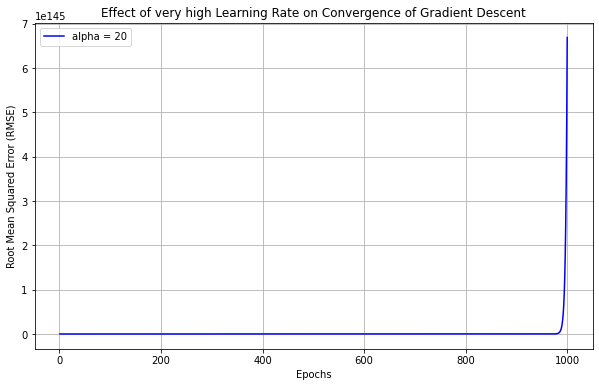

In [ ]:
rmse6 = rgr.fit(train_X, train_y, epochs = 1000, learning_rate = 20)
plt.plot(range(1, 1001), rmse6, color='blue', label = 'alpha = 20')

plt.rcParams['figure.figsize'] = (10, 6)
plt.grid()
plt.title('Effect of very high Learning Rate on Convergence of Gradient Descent')
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.legend()